In [1]:
# Dependencies

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

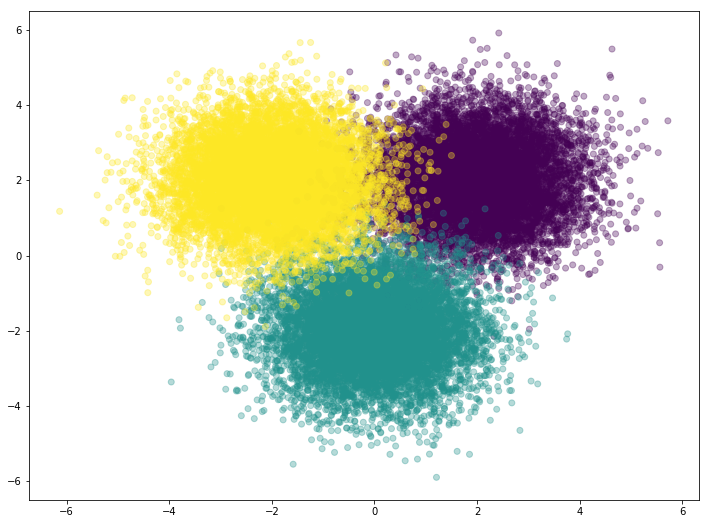

In [2]:
# Simulate Data

D = 2
K = 3
N = int(K*1e4)

X0 = np.random.randn((N//K),D) + np.array([2,2])
X1 = np.random.randn((N//K),D) + np.array([0,-2])
X2 = np.random.randn((N//K),D) + np.array([-2,2])
X = np.vstack((X0,X1,X2))

y = np.array([0]*(N//K) + [1]*(N//K) + [2]*(N//K))

plt.figure(figsize = (12,9))
plt.scatter(X[:,0],X[:,1],c = y,alpha = 0.3333)

In [3]:
# Data prep

Y = np.zeros((N,K))

for i in range(N):
    Y[i,y[i]] = 1

In [4]:
# class definitions

class ReLU():
    
    @staticmethod
    def f(H):
        return H*(H > 0)
    
    @staticmethod
    def df(Hbar):
        return 1*(Hbar > 0)

class softmax():
    
    @staticmethod
    def f(H):
        eH = np.exp(H)
        return eH / eH.sum(axis=1, keepdims=True)
    
    @staticmethod
    def df(Hbar):
        return Hbar*(1 - Hbar)

In [5]:
# helper functions

def feed_forward_train(X,W,b,Gamma,mu,sigma2,af,**kwargs):
    
    # dimentions
    L = len(W)
    
    # kwargs
    epsilon = kwargs['epsilon'] if 'epsilon' in kwargs else 1e-8
    
    # set collection dictionaries
    H,Hbar,Z = {},{},{}
    
    # input
    H[1] = np.matmul( X, W[1] )
    Hbar[1] = Gamma[1] * ((H[1] - mu) / np.sqrt(sigma2 + epsilon)) + b[1]
    Z[1] = af[1].f( Hbar[1] )
    
    # layers
    for l in range(2,L+1):
        H[l] = np.matmul( Z[l-1], W[l] )
        Hbar[l] = Gamma[l] * ((H[l] - mu) / np.sqrt(sigma2 + epsilon)) + b[l]
        Z[l] = af[l].f( Hbar[l] )
        
    return H, Hbar, Z

def cross_entropy(Y, P):
    return -np.sum(Y*np.log(P))

def accuracy(Y, P):
    return np.mean(Y.argmax(axis = 1) == P.argmax(axis = 1))
    

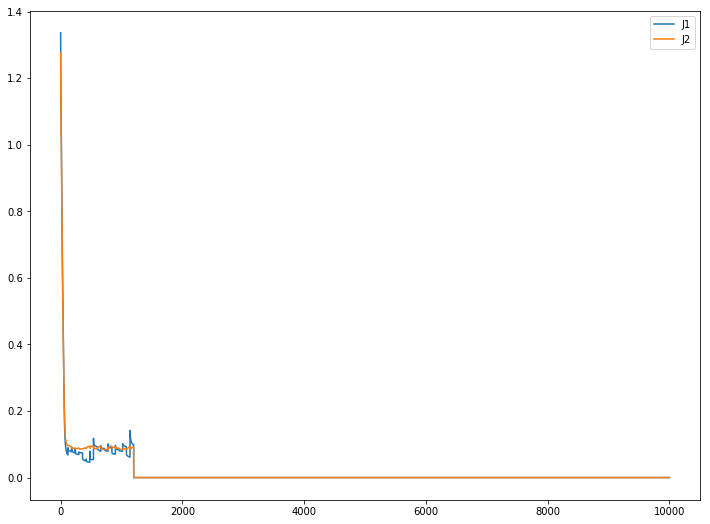

In [61]:
# Build the Model
L = 2

M = {1:4}

W = {
    1: np.random.randn(D,M[1]) / np.sqrt(D),
    2: np.random.randn(M[1],K) / np.sqrt(M[1])
    }

beta = {
    1: np.random.randn(1,M[1]),
    2: np.random.randn(1,K)
    }

Gamma = {
    1: np.random.randn(1,M[1]),
    2: np.random.randn(1,K)
    }

af = {
    1: ReLU(),
    2: softmax()
    }

# Train the Model using Batch Normalization

eta = 1e-3
alpha = 0.99
mu = 0
sigma2 = 0
epsilon = 1e-10

epochs = 20
batch_size = 500
batches = N//batch_size

J1 = np.zeros(epochs*batch_size)
J2 = np.zeros_like(J1)
mu = np.zeros((epochs,batches))
sigma2 = np.zeros_like(mu)

dZ, dHbar, dGamma, dbeta, dH, dW = {},{},{},{},{},{}


for epoch in range(epochs):
    
    idx = np.random.permutation(N)
    X,Y = X[idx,:],Y[idx,:]
    
    for batch in range(batches):
        
        X_B = X[(i*batch_size):((i+1)*batch_size),:]
        Y_B = Y[(i*batch_size):((i+1)*batch_size),:]
        
        mu_B = X_B.sum() / batch_size
        sigma2_B = ((X_B - mu_B)**2).sum() / (batch_size - 1)
        
        H, Hbar, Z = feed_forward_train(X_B, W, beta, Gamma, mu_B, sigma2_B, af, epsilon=epsilon )
        J1[batch + (epoch*batches)] = cross_entropy(Y_B, Z[L]) / batch_size
        mu[epoch,batch] = mu_B
        sigma2[epoch,batch] = sigma2_B

        # output layer
        dHbar[L] = Z[L] - Y_B  
        dGamma[L] = (dHbar[L] * (H[L] - mu_B) / np.sqrt(sigma2_B + epsilon)).sum(axis=0, keepdims=True)
        Gamma[L] -= eta*  dGamma[L]
        dH[L] = dHbar[L] * Gamma[L] / np.sqrt(sigma2_B + epsilon)
        dW[L] = np.matmul( Z[L-1].T, dH[L] )
        dbeta[L] = dHbar[L].sum(axis=0, keepdims=True)
        W[L] -= eta * dW[L]
        beta[L] -= eta * dbeta[L]
        
        # hidden layers
        for l in np.arange(2,L)[::-1]:
            dZ[l] = np.matmul( dH[l+1], W[l+1].T )
            dHbar[l] = dZ[l] * af[l].df( Hbar[l] )
            dGamma[l] = (dHbar[l] * (H[l] - mu_B) / np.sqrt(sigma2_B + epsilon)).sum(axis=0, keepdims=True)
            Gamma[l] -= eta * dGamma[l]
            dH[l] = dHbar[l] * Gamma[l] / np.sqrt(sigma2_B + epsilon)
            dW[l] = np.matmul( Z[l-1].T , dH[l])
            dbeta[l] = dHbar[l].sum(axis=0, keepdims=True)
            W[l] -= eta * dW[l]
            beta[l] -= eta * dbeta[l]
            
        # output layer
        dZ[1] = np.matmul( dH[2], W[2].T )
        dHbar[1] = dZ[1] * af[1].df( Hbar[1] )
        dGamma[1] = (dHbar[1] * (H[1] - mu_B) / np.sqrt(sigma2_B + epsilon)).sum(axis=0, keepdims=True)
        Gamma[1] -= eta * dGamma[1]
        dH[1] = dHbar[1] * Gamma[1] / np.sqrt(sigma2_B + epsilon)
        dW[1] = np.matmul( X_B.T, dH[1] )
        dbeta[1] = dHbar[1].sum(axis=0, keepdims=True)
        W[1] -= eta * dW[1]
        beta[1] -= eta * dbeta[1]
        
        H, Hbar, Z = feed_forward_train(X, W, beta, Gamma, mu_B, sigma2_B, af, epsilon=epsilon )
        J2[batch + (epoch*batches)] = cross_entropy(Y, Z[L]) / N
             
plt.figure(figsize = (12,9))
plt.plot(J1, label='J1')
plt.plot(J2, label='J2')
plt.legend()

In [62]:
# Report Accuracy

P = feed_forward_train(X, W, beta, Gamma, mu.mean(), sigma2.mean(), af, epsilon=epsilon)[-1][L]

print("Accuracy: {}".format(accuracy(Y,P)))

Accuracy: 0.9662666666666667
